# Goals

* Create a tiledb-soma db for the Tahoe-100 dataset

# Vars

In [1]:
work_dir = '/processed_datasets/scRecount/tahoe'

# Init

In [2]:
import os
from glob import glob
import pandas as pd
import tiledbsoma
import tiledbsoma.io
import scanpy as sc
import numpy as np
import plotnine as pn

In [3]:
pn.theme_set(pn.theme_bw())

In [4]:
db_uri = os.path.join(work_dir, 'tiledb-soma')
#db_uri = os.path.join(work_dir, 'tiledb-soma-mini')
db_uri

'/processed_datasets/scRecount/tahoe/tiledb-soma'

# Create

In [11]:
# list all *.h5ad.gz files in the work directory
files = sorted(glob(os.path.join(work_dir, '*.h5ad.gz')))
files

['/processed_datasets/scRecount/tahoe/plate10_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate11_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate12_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate13_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate14_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate1_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate2_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate3_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate4_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate5_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate6_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate7_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate8_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate9_filtered.h5ad.gz']

> Ran via tmux to prevent disconnection

```bash
./scripts/tiledb-loader-tahoe.py \
  --h5ad-ext h5ad.gz \
  --db-uri /processed_datasets/scRecount/tahoe/tiledb-soma \
  /processed_datasets/scRecount/tahoe/ \
  > tiledb-loader-tahoe.log 2>&1 
```

# Summary

In [5]:
# get colnames
with tiledbsoma.open(db_uri) as exp:
    print(exp.obs.schema)

soma_joinid: int64 not null
BARCODE_SUB_LIB_ID: large_string
sample: dictionary<values=string, indices=int32, ordered=0>
species: dictionary<values=string, indices=int32, ordered=0>
gene_count: int64
tscp_count: int64
mread_count: int64
bc1_wind: int64
bc2_wind: int64
bc3_wind: int64
bc1_well: dictionary<values=string, indices=int32, ordered=0>
bc2_well: dictionary<values=string, indices=int32, ordered=0>
bc3_well: dictionary<values=string, indices=int32, ordered=0>
id: dictionary<values=string, indices=int32, ordered=0>
drugname_drugconc: dictionary<values=string, indices=int32, ordered=0>
drug: dictionary<values=string, indices=int32, ordered=0>
INT_ID: double
NUM.SNPS: double
NUM.READS: double
demuxlet_call: dictionary<values=string, indices=int32, ordered=0>
BEST.GUESS: dictionary<values=string, indices=int32, ordered=0>
BEST.LLK: double
NEXT.GUESS: dictionary<values=string, indices=int32, ordered=0>
NEXT.LLK: double
DIFF.LLK.BEST.NEXT: double
BEST.POSTERIOR: double
SNG.POSTERIOR: 

## Obs

In [6]:
# obs per sample
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read()
        .concat()
        .group_by(['sample'])
        .aggregate([
            ([], 'count_all'),
        ])
        .sort_by([("count_all", "descending")])
        .to_pandas()
    )
print(df.shape)
df.head()

(1344, 2)


,sample,count_all
0,smp_2553,215364
1,smp_2643,202116
2,smp_2177,196600
3,smp_2613,195537
4,smp_2638,192968


In [7]:
# total obs
df["count_all"].sum()

np.int64(100648790)

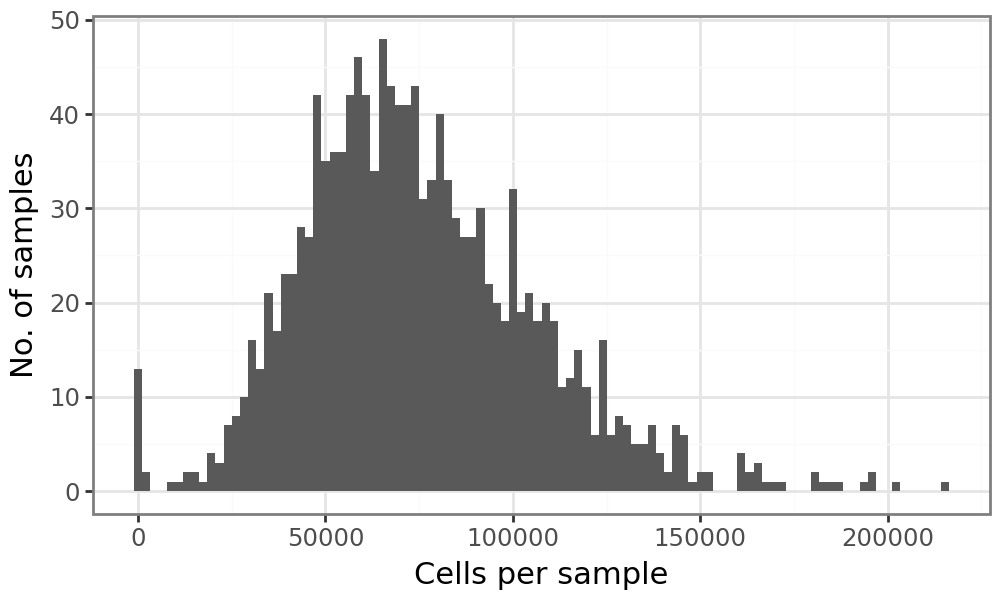

In [8]:
# plot reads per cell (barcode)
p = (
    pn.ggplot(df, pn.aes(x="count_all")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Cells per sample", y="No. of samples") +
    pn.theme(figure_size=(5,3))
    )
p

In [9]:
# cells per drug
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["drug"])
        .concat()
        .group_by(["drug"])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
print(df.shape)
df.head()

(380, 2)


,drug,count_all
0,8-Hydroxyquinoline,303241
1,Chlorhexidine (diacetate),428705
2,Trifluridine,272488
3,Berbamine,449664
4,Retinoic acid,313463


In [10]:
# cells per cell line/name
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["cell_line", "cell_name"])
        .concat()
        .group_by(["cell_line", "cell_name"])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
print(df.shape)
df.head()

(50, 3)


,cell_line,cell_name,count_all
0,CVCL_0371,KATO III,2332035
1,CVCL_1731,SW 900,1791184
2,CVCL_1097,C32,2098357
3,CVCL_0480,PANC-1,4170586
4,CVCL_0023,A549,2664482


In [12]:
# cells per phase
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["phase"])
        .concat()
        .group_by(["phase"])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
print(df.shape)
df.head()

(3, 2)


,phase,count_all
0,G1,62969737
1,G2M,29455730
2,S,8223323


In [17]:
# cells per phase
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["pass_filter"])
        .concat()
        .group_by(["pass_filter"])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
print(df.shape)
df.head()

(2, 2)


,pass_filter,count_all
0,full,95624334
1,minimal,5024456


### Reads

In [10]:
# reads per cell
with tiledbsoma.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["BARCODE_SUB_LIB_ID", "NUM.READS"])
        .concat()
        .group_by(["BARCODE_SUB_LIB_ID"])
        .aggregate([
            (["NUM.READS"], "sum"),
        ])
        .sort_by([("NUM.READS_sum", "descending")])
        .to_pandas()
    )
df

: 

In [66]:
# stats
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df["NUM.READS_sum"].describe())

count   4705402
mean        124
std         113
min           7
25%          62
50%          92
75%         147
max        6570
Name: NUM.READS_sum, dtype: float64


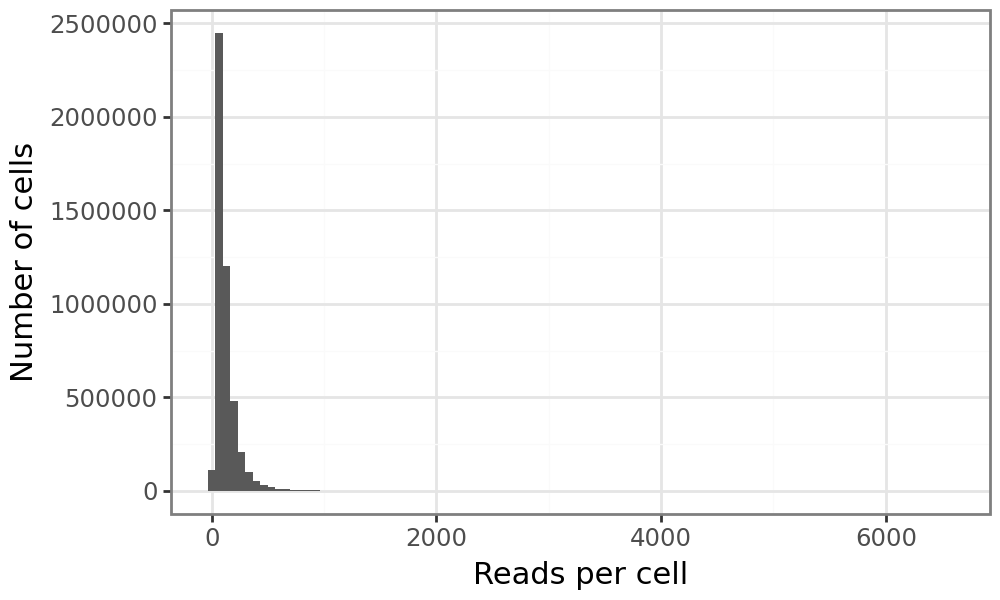

In [67]:
# plot reads per cell (barcode)
p = (
    pn.ggplot(df, pn.aes(x="NUM.READS_sum")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Reads per cell", y="Number of cells") +
    pn.theme_bw() +
    pn.theme(figure_size=(5,3))
    )
p

In [70]:
# gene count per cells
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["BARCODE_SUB_LIB_ID", "gene_count"])
        .concat()
        .to_pandas()
    )
print(df.shape)
df.head()

(4705402, 2)


,BARCODE_SUB_LIB_ID,gene_count
0,01_001_117-lib_1009,1110
1,01_001_122-lib_1009,1011
2,01_001_172-lib_1009,835
3,01_002_058-lib_1009,754
4,01_002_063-lib_1009,1546


In [72]:
# stats
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df["gene_count"].describe())

count   4705402
mean       1208
std         733
min         253
25%         718
50%        1011
75%        1469
max       12600
Name: gene_count, dtype: float64


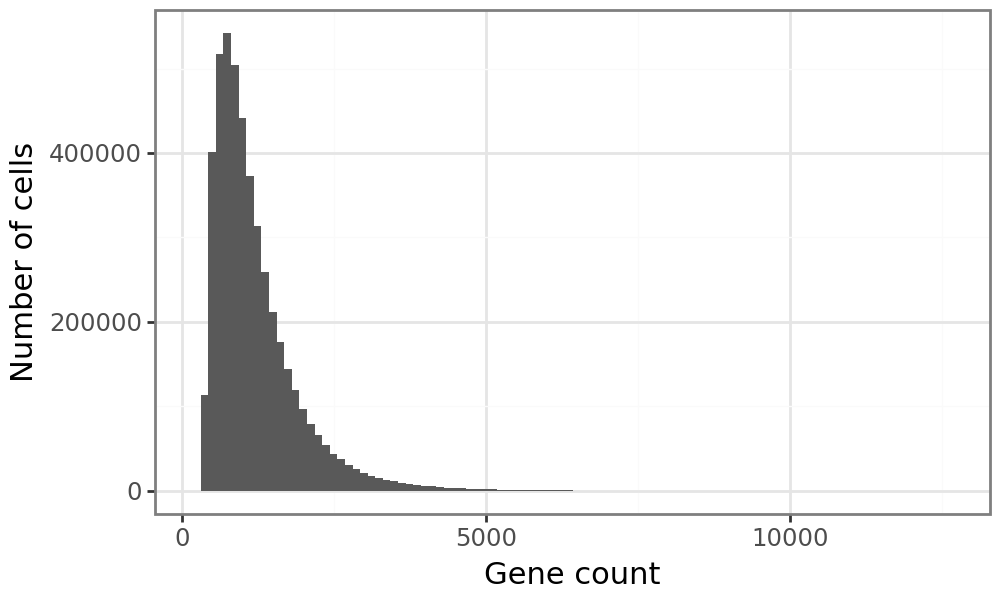

In [71]:
# plot reads per gene (barcode)
p = (
    pn.ggplot(df, pn.aes(x="gene_count")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Gene count", y="Number of cells") +
    pn.theme_bw() +
    pn.theme(figure_size=(5,3))
    )
p

# Sandbox

In [11]:
# view all metadata
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read()
        .concat()
        .slice(0,10) 
        .to_pandas()
    )
pd.set_option('display.max_columns', 100)
print(df.shape)
df.head()

(10, 45)


,soma_joinid,BARCODE_SUB_LIB_ID,sample,species,gene_count,tscp_count,mread_count,bc1_wind,bc2_wind,bc3_wind,bc1_well,bc2_well,bc3_well,id,drugname_drugconc,drug,INT_ID,NUM.SNPS,NUM.READS,demuxlet_call,BEST.GUESS,BEST.LLK,NEXT.GUESS,NEXT.LLK,DIFF.LLK.BEST.NEXT,BEST.POSTERIOR,SNG.POSTERIOR,cell_line,SNG.BEST.LLK,SNG.NEXT.GUESS,SNG.NEXT.LLK,SNG.ONLY.POSTERIOR,DBL.BEST.GUESS,DBL.BEST.LLK,DIFF.LLK.SNG.DBL,sublibrary,BARCODE,pcnt_mito,S_score,G2M_score,phase,cell_line_orig,pass_filter,cell_name,obs_id
0,0,01_001_053-lib_2064,smp_2743,hg38,1154,1650,1935,1,1,53,A1,A1,E5,recxbJxJOaZM90Poa,"[('8-Hydroxyquinoline', 5.0, 'uM')]",8-Hydroxyquinoline,0.0,98.0,100.0,singlet,"CVCL_0371,CVCL_0371,0.00",-30.50,"CVCL_0366,CVCL_0371,0.50",-29.17,-1.33,-35.0,1.0,CVCL_0371,-30.50,CVCL_0366,-44.10,0.0,"CVCL_0366,CVCL_0371,0.50",-29.17,-1.33,lib_2064,01_001_053,0.045455,-0.068190,-0.259615,G1,CVCL_0371,full,KATO III,01_001_053-lib_2064
1,1,01_001_141-lib_2064,smp_2743,hg38,1132,1748,2073,1,1,141,A1,A1,p2.D9,recxbJxJOaZM90Poa,"[('8-Hydroxyquinoline', 5.0, 'uM')]",8-Hydroxyquinoline,1.0,68.0,70.0,singlet,"CVCL_1731,CVCL_1731,0.00",-22.14,"CVCL_1731,CVCL_1239,0.50",-22.37,0.23,-27.0,1.0,CVCL_1731,-22.14,CVCL_1381,-25.50,0.0,"CVCL_1731,CVCL_1239,0.50",-22.37,0.23,lib_2064,01_001_141,0.039474,-0.092190,-0.322115,G1,CVCL_1731,full,SW 900,01_001_141-lib_2064
2,2,01_002_014-lib_2064,smp_2743,hg38,916,1285,1536,1,2,14,A1,A2,B2,recxbJxJOaZM90Poa,"[('8-Hydroxyquinoline', 5.0, 'uM')]",8-Hydroxyquinoline,2.0,68.0,69.0,singlet,"CVCL_1097,CVCL_1097,0.00",-15.64,"CVCL_1097,CVCL_1731,0.50",-15.86,0.22,-20.0,1.0,CVCL_1097,-15.64,CVCL_1731,-19.08,0.0,"CVCL_1097,CVCL_1731,0.50",-15.86,0.22,lib_2064,01_002_014,0.017121,-0.072190,-0.125000,G1,CVCL_1097,full,C32,01_002_014-lib_2064
3,3,01_002_181-lib_2064,smp_2743,hg38,1857,2946,3430,1,2,181,A1,A2,p2.H1,recxbJxJOaZM90Poa,"[('8-Hydroxyquinoline', 5.0, 'uM')]",8-Hydroxyquinoline,5.0,184.0,189.0,singlet,"CVCL_1097,CVCL_1097,0.00",-57.00,"CVCL_1119,CVCL_1097,0.50",-58.38,1.39,-62.0,1.0,CVCL_1097,-57.00,CVCL_1119,-82.44,0.0,"CVCL_1119,CVCL_1097,0.50",-58.38,1.39,lib_2064,01_002_181,0.017651,0.002667,0.278846,G2M,CVCL_1097,full,C32,01_002_181-lib_2064
4,4,01_003_056-lib_2064,smp_2743,hg38,731,969,1118,1,3,56,A1,A3,E8,recxbJxJOaZM90Poa,"[('8-Hydroxyquinoline', 5.0, 'uM')]",8-Hydroxyquinoline,6.0,64.0,65.0,singlet,"CVCL_0480,CVCL_0480,0.00",-19.37,"CVCL_0480,CVCL_0366,0.50",-18.90,-0.47,-24.0,1.0,CVCL_0480,-19.37,CVCL_0366,-26.26,0.0,"CVCL_0480,CVCL_0366,0.50",-18.90,-0.47,lib_2064,01_003_056,0.041280,-0.020190,-0.144231,G1,CVCL_0480,full,PANC-1,01_003_056-lib_2064


In [1]:
import scanpy as sc

In [2]:
infile = "/processed_datasets/scRecount/tahoe/plate3_filtered.h5ad.gz"
adata = sc.read_h5ad(infile)
adata

AnnData object with n_obs × n_vars = 4705402 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name'

In [3]:
adata.obs.index[:10]

Index(['01_001_117-lib_1009', '01_001_122-lib_1009', '01_001_172-lib_1009',
       '01_002_058-lib_1009', '01_002_063-lib_1009', '01_002_094-lib_1009',
       '01_002_151-lib_1009', '01_002_163-lib_1009', '01_002_187-lib_1009',
       '01_003_059-lib_1009'],
      dtype='object', name='BARCODE_SUB_LIB_ID')

In [6]:
adata.obs.index[:10]

Index(['01_001_117-lib_1009', '01_001_122-lib_1009', '01_001_172-lib_1009',
       '01_002_058-lib_1009', '01_002_063-lib_1009', '01_002_094-lib_1009',
       '01_002_151-lib_1009', '01_002_163-lib_1009', '01_002_187-lib_1009',
       '01_003_059-lib_1009'],
      dtype='object', name='BARCODE_SUB_LIB_ID')

# sessionInfo

In [82]:
!mamba list

# packages in environment at /home/nickyoungblut/miniforge3/envs/tiledb:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
aiohappyeyeballs          2.4.4              pyhd8ed1ab_1    conda-forge
aiohttp                   3.11.11         py312h178313f_0    conda-forge
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
anndata                   0.11.3             pyhd8ed1ab_0    conda-forge
array-api-compat          1.10.0             pyhd8ed1ab_0    conda-forge
asttokens                 3.0.0              pyhd8ed1ab_1    conda-forge
attrs                     25.1.0             pyh71513ae_0    conda-forge
aws-c-auth                0.8.1                h205f482_0    conda-forge
aws-c-cal                 0.8.1                h1a47875_3    conda-forge
aws-c-common              0.10.6               hb9d3cd8